# Main

## Define variables and import the main library

In [ ]:
project_directory = '/srv/codathon'
import os, sys
links_dir = os.path.join(project_directory, 'data', 'all_gene_expression_files_in_target', 'links')
annotation_file = os.path.join(project_directory, 'data', 'gencode.v22.annotation.gtf')
sample_sheet_file = os.path.join(project_directory, 'data', 'gdc_sample_sheet.2020-07-02.tsv')
metadata_file = os.path.join(project_directory, 'data', 'metadata.cart.2020-07-02.json')
if os.path.join(project_directory, 'checkout') not in sys.path:
    sys.path.append(os.path.join(project_directory, 'checkout'))
import target_class_lib as tc

import os
import pickle



## Load the data downloaded from the GDC Data Portal

In [ ]:
df_samples, df_counts = tc.load_gdc_data(sample_sheet_file, metadata_file, links_dir)

## Calculate the FPKM and FPKM-UQ dataframes, and check them with known values if the needed datafiles are present

In [ ]:
df_counts.shape

In [ ]:
df_fpkm, df_fpkm_uq = tc.get_fpkm(df_counts, annotation_file, df_samples, links_dir)

## Remove from the samples and intensities the samples that correspond to multiple cases (i.e., people)

In [ ]:
print(df_fpkm.shape)
print(df_fpkm_uq.shape)

In [ ]:
df_samples, indexes_to_keep, _ = tc.drop_multiperson_samples(df_samples)
df_counts = df_counts.iloc[indexes_to_keep,:]
df_fpkm = df_fpkm.iloc[indexes_to_keep,:]
df_fpkm_uq = df_fpkm_uq.iloc[indexes_to_keep,:]

## Perform exploratory data analysis on the sample labels

In [ ]:
tc.eda_labels(df_samples)

## Plot histograms of the numerical columns of the samples/labels before and after cutoffs are applied, and print out a summary of what was removed

In [ ]:
df_samples, indexes_to_keep = tc.remove_bad_samples(df_samples)
df_counts = df_counts.iloc[indexes_to_keep,:]
df_fpkm = df_fpkm.iloc[indexes_to_keep,:]
df_fpkm_uq = df_fpkm_uq.iloc[indexes_to_keep,:]

## Perform exploratory data analysis on the filtered sample labels

In [ ]:
tc.eda_labels(df_samples)

## Print some random data for us to spot-check in the files themselves to manually ensure we have a handle on the data arrays

In [ ]:
tc.spot_check_data(df_samples, df_counts, df_fpkm, df_fpkm_uq)

## Calculate the TPM using the counts and gene lengths
Note I've confirmed sufficient equality using TPM calculation using FPKM and FPKM-UQ

In [ ]:
df_tpm = tc.get_tpm(df_counts, annotation_file)

In [ ]:
df_tpm.shape
df_tpm.index = df_tpm.index.str.replace('-', '_')

## Add a labels column based on the project id and sample type columns and show the unique values by decreasing frequency

In [ ]:
df_samples['label 1'] = df_samples['project id'] + ', ' + df_samples['sample type']
print(df_samples['label 1'].value_counts())

## Run the variance-stabilizing transformation using DESeq2 using this most-detailed set of labels

In [ ]:
#X1, y1 = tc.run_vst(df_counts, df_samples['label 1'], project_directory)

In [ ]:
df_samples.index = df_samples.index.str.replace('-', '_')

In [ ]:
df_counts.index = df_counts.index.str.replace('-', '_')

In [ ]:
#print(X1.shape)
#print(y1.shape)
X1=df_tpm

#y1=
y1=df_samples['label 1']

In [ ]:
X1.index.equals(y1.index)

In [ ]:
X1 = X1.sort_index()

In [ ]:
y1 = y1.sort_index()

In [ ]:
y1 = y1.sort_index()

# Autoencoder model

In [36]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from numpy.random import seed
from sklearn import preprocessing
import pandas as pd
import sklearn.decomposition as sk_decomp
import sklearn.manifold as sk_manif

In [37]:
y1_num=y1.copy()

#encode the cancer type and store the coding in y1_dic
y1_v=y1_num.value_counts().index.tolist()
y1_dic = {k: v for v, k in enumerate(y1_v)}

#covert cancer types based on the coding 
for k, v in y1_dic.items():
    y1_num.replace(k, v, inplace = True)

#normalize each sample first and standardize each feature independently (zero mean and unit variance)
#this is further used for model training
X1_std = preprocessing.scale(X1)
X1_std_norm = preprocessing.normalize(X1_std)
X1_std_norm = pd.DataFrame(data=X1_std_norm, index=X1.index, columns=X1.columns)

#standardize each feature independently (zero mean and unit variance) first and normalize each sample
X1_norm = preprocessing.normalize(X1)
X1_norm_std = preprocessing.scale(X1_norm)
X1_norm_std = pd.DataFrame(data=X1_norm_std, index=X1.index, columns=X1.columns)

In [38]:
#set up autoencoder
#split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X1_std_norm, y1_num, train_size = 0.7, random_state = seed(42))
ncol = X1.shape[1]
input_dim = Input(shape = (ncol, ))
#define the dimentsion of encoder
encoding_dim = 600
#define the encoder layer
encoded1 = Dense(2000, activation = 'relu')(input_dim)
encoded2 = Dense(encoding_dim, activation = 'relu')(encoded1)
#define the decoder layer
decoded1 = Dense(2000, activation = 'sigmoid')(encoded2)
decoded2 = Dense(ncol, activation = 'sigmoid')(decoded1)
#combine encoder and decoder into an autoencoder model
autoencoder = Model(input_dim, decoded2)
#configure and train the autoencoder
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')
autoencoder.summary()
autoencoder.fit(X_train, X_train, epochs=5, batch_size=100, shuffle=True, validation_data=(X_test, X_test))
#the encoder to extract the reduced dimension
encoder = Model(input_dim, encoded2)
encoded_input = Input(shape = (encoding_dim, ))
encoded_out = encoder.predict(X_test)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60483)]           0         
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              120968000 
_________________________________________________________________
dense_5 (Dense)              (None, 600)               1200600   
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              1202000   
_________________________________________________________________
dense_7 (Dense)              (None, 60483)             121026483 
Total params: 244,397,083
Trainable params: 244,397,083
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
9/9 [==============================] - 6s 703ms/step - loss: 0.0701 - val_loss: 0.0013
Epoch 2/5

In [39]:
#decode the cancer class in the test
for k, v in y1_dic.items():
    Y_test.replace(v, k, inplace = True)

Text(0.5, 1.0, 'autoencoder-tSNE')

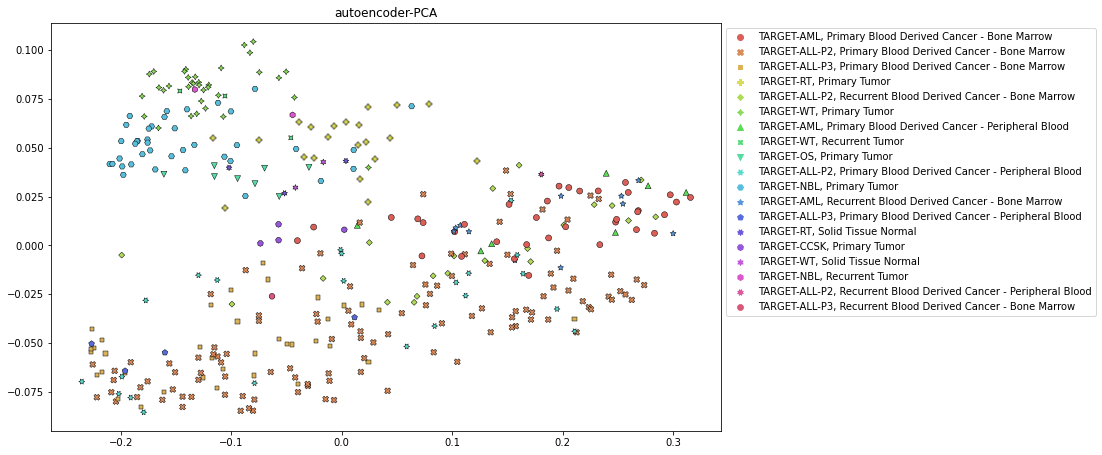

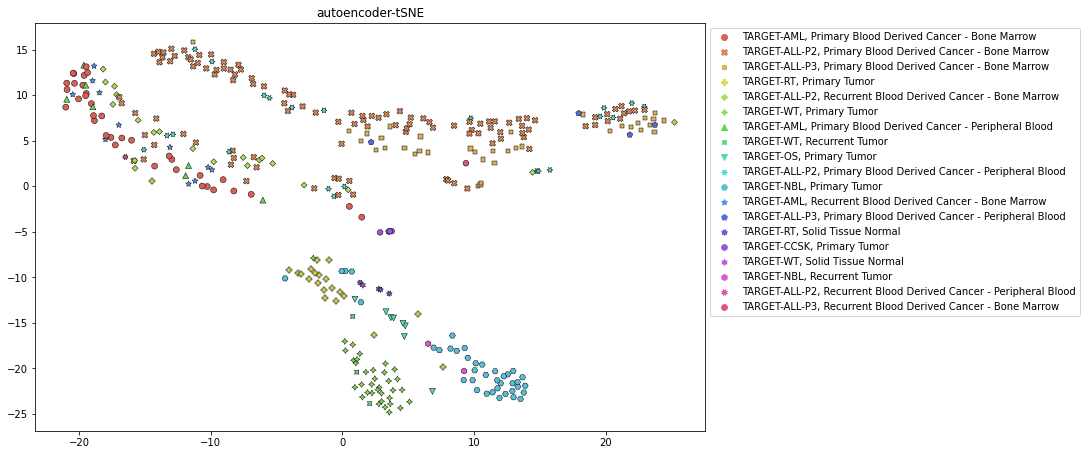

In [40]:
#further dimension reduction using pca or tsne
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(encoded_out)    
ax_pca = tc.plot_unsupervised_analysis(pca_res, Y_test)
ax_pca.set_title('autoencoder-PCA')

tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(encoded_out)
ax_tsne = tc.plot_unsupervised_analysis(tsne_res, Y_test)
ax_tsne.set_title('autoencoder-tSNE')

#ae_2d = plt.scatter(encoded_out[:,0], encoded_out[:,1],c=Y_test)


## Create and plot PCA and tSNE analyses using the variance-stabilizing-transformed data from DESeq2

In [ ]:
# Perform PCA
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(X1.iloc[:,:500])
y1
#pca

In [ ]:
_res = pca.fit_transform(X1.iloc[:,:])
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(pca_res, y1)
ax.set_title('PCA - variance-stabilizing transformation')

In [ ]:
res = pca.fit_transform(X1.iloc[:,:])
#print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(res, y1)
ax.set_title('PCA - variance-stabilizing transformation')

In [ ]:
# Perform tSNE analysis
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(X1.iloc[:,:500])
#tsne_res = tsne.fit_transform(X1.iloc[:,:])
ax = tc.plot_unsupervised_analysis(tsne_res, y1)
ax.set_title('tSNE - variance-stabilizing transformation')

From the above tSNE plot, we find many interesting things, e.g.:

* ALL is spread out in multiple places (all oranges/yellows and early greens), into four main clusters; in particular:
  * ALL/P2/PBDC (both /BM and /PB) is located in three of them
  * ALL/P2/RBDC (i.e., /BM) is basically isolated to one of them
  * ALL/P3 is basically in the fourth cluster
  * Note that even though ALL/P3 is supposed to be the "ambiguously myeloid" one (ALAL, acute leukemia of ambiguous lineage), it is primarily ALL/P2 that seems to sometimes be confused with AML
* AML has its own single cluster
* There are some ALL in an AML cluster and vice versa, and the two corresponding clusters are near each other
* CCSK is very tightly clustered
* NBL has its own cluster, with one RT instance that may be misclassified
* OS is tightly clustered, except for two samples in WT, which may indicate that they are misclassified
* Aside from the one possibly misclassified RT, they are all solidly clustered
* WT is clustered together
* The two normal species are very tightly clustered together
* Note the three kidney tumor types (RT, WT, CCSK) are relatively close together (and are also close to OS and normal)

## Based on the above observations, make a new set of more sensible labels

See comments in each line in the following code block

In [ ]:
df_samples['label 2'] = df_samples['label 1'] # initialize the new label (2) to the original, most-detailed label (1)
df_samples['label 2'][df_samples['label 2'].str.contains('normal', case=False, regex=False)] = 'TARGET-Normal' # set to "TARGET-Normal" any label including "normal" in its original name
df_samples['label 2'] = df_samples['label 2'].str.split(pat=', ', expand=True)[0] # otherwise, just set the label to the project ID (see definition of 'label 1' above)
df_samples['label 2'] = df_samples['label 2'].str.split(pat='-', expand=True)[1] # finally, at the same time, both remove "TARGET-" from the labels and, for ALL, remove "-PX", where X={1,2,3}
print(df_samples['label 2'].value_counts()) # print the final labels counts

## Re-label the unsupervised plots above, just as a quick check of our new labeling scheme

In [ ]:
# Define the new labels
y = df_samples['label 2'].copy()
y.index = y.index.str.replace('-', '_')
y = y.loc[y1.index] # order them the same way as the PCA/tSNE results we already calculated

# Redo the plots, with appropriate sorting so that the labels are in alphabetical order
sorting_indexes = y.to_numpy().argsort(axis=0)
ax = tc.plot_unsupervised_analysis(pca_res[sorting_indexes,:], y.iloc[sorting_indexes])
ax.set_title('PCA - variance-stabilizing transformation - with new labels')
ax = tc.plot_unsupervised_analysis(tsne_res[sorting_indexes,:], y.iloc[sorting_indexes])
ax.set_title('tSNE - variance-stabilizing transformation - with new labels')

Note that had we not previously plotted the most detailed set of labels, we would have been left forever wondering why the two distinct clusters of AML data.

## Now actually run the variance-stabilizing transformation using DESeq2 on the re-labeled dataset

In [ ]:
#X2, y2 = tc.run_vst(df_counts, df_samples['label 2'], project_directory)

In [ ]:
#Revert to TPM
X2 = df_tpm

In [ ]:
X2 = X2.sort_index()

In [ ]:
y2 = df_samples['label 1']
#df_tpm

In [ ]:
df_samples.head

In [ ]:
X2.index.equals(y2.index)

## Run PCA and tSNE on the new dataset

In [ ]:
# Perform PCA
import sklearn.decomposition as sk_decomp
pca = sk_decomp.PCA(n_components=10)
pca_res = pca.fit_transform(X2.iloc[:,:500])
print('Top {} PCA explained variance ratios: {}'.format(10, pca.explained_variance_ratio_))
ax = tc.plot_unsupervised_analysis(pca_res, y2)
ax.set_title('PCA - variance-stabilizing transformation')

# Perform tSNE analysis
import sklearn.manifold as sk_manif
tsne = sk_manif.TSNE(n_components=2)
tsne_res = tsne.fit_transform(X2.iloc[:,:500])
ax = tc.plot_unsupervised_analysis(tsne_res, y2)
ax.set_title('tSNE - variance-stabilizing transformation')

## Create a figure helping to explore the extent of sampling each unique label in the dataset (i.e., each group)

In [ ]:
#fig = tc.explore_sample_size(X2, y2, tsne_res, n_range=range(100,601,100))
#fig = tc.explore_sample_size(X2, y2, tsne_res, n_range=[1,3,12,50,100,600])
#fig.savefig(os.path.join(project_directory, 'data', 'exploring_sample_size_100_601_100.png'), facecolor='w', dpi=150)

## Run some random forest classification models on the data, saving the results and plotting the accuracies of the models on the entire input datasets

In [ ]:
# Get a reasonable set of sample sizes
possible_n = [x for x in range(1,13)] + [x for x in range(15,46,5*2)] + [x for x in range(50,101,10*2)]

# Determine the samples of just particular types
nbl_or_normal_samples = (y2.isin(['TARGET-RT, Solid Tissue Normal','TARGET-NBL, Recurrent Blood Derived Cancer - Bone Marrow','TARGET-NBL, Recurrent Tumor', 'TARGET-OS, Primary Tumor','TARGET-RT, Solid Tissue Normal'])).to_numpy() | (y2=='Normal').to_numpy() # get samples that are NBL or Normal
aml_or_normal_samples = (y2.isin(['TARGET-AML, Recurrent Blood Derived Cancer - Bone Marrow','TARGET-AML, Primary Blood Derived Cancer - Peripheral Blood','TARGET-AML, Recurrent Blood Derived Cancer - Peripheral Blood'])).to_numpy() | (y2=='Normal').to_numpy() # get samples that are AML or Normal

In [ ]:
# Generate the random forest classification models

#todo launch on biowulf

#accuracies, possible_n, rnd_clf_holder = tc.generate_random_forest_models(X2, y2, project_directory, 'tpm_all_classes', ntrials=30, possible_n=possible_n) # all data

In [ ]:
accuracies_nbl, possible_n_nbl, rnd_clf_holder_nbl = tc.generate_random_forest_models(X2.iloc[nbl_or_normal_samples,:], y2.iloc[nbl_or_normal_samples], project_directory, 'tpm_nbl_vs_normal', possible_n=possible_n[-10:], ntrials=30) # just NBL/Normal

In [ ]:
accuracies_aml, possible_n_aml, rnd_clf_holder_aml = tc.generate_random_forest_models(X2.iloc[aml_or_normal_samples,:], y2.iloc[aml_or_normal_samples], project_directory, 'tpm_aml_vs_normal', possible_n=possible_n[-10:], ntrials=30) # just AML/Normal

In [ ]:
# Plot the accuracy vs. sample size for each study type
tc.plot_accuracy_vs_sample_size(accuracies, possible_n, 'all classes')
tc.plot_accuracy_vs_sample_size(accuracies_nbl, possible_n_nbl, 'NBL vs. normal')
tc.plot_accuracy_vs_sample_size(accuracies_aml, possible_n_aml, 'AML vs. normal')

print('Note a random model would get an accuracy score of 0.125')

## Determine the genes in decreasing order of average feature importance

In [ ]:
# At least for the time being, this step takes a few minutes
important_genes = tc.calculate_average_feature_importance(X2.columns, rnd_clf_holder, num_last_sample_sizes=10)
important_genes_nbl = tc.calculate_average_feature_importance(X2.columns, rnd_clf_holder_nbl, num_last_sample_sizes=10)
important_genes_aml = tc.calculate_average_feature_importance(X2.columns, rnd_clf_holder_aml, num_last_sample_sizes=10)

## Print the top differentiating genes in each study

In [ ]:
print('\nAll data\n', important_genes[:20])
print('\nNBL vs. normal\n', important_genes_nbl[:20])
print('\nAML vs. normal\n', important_genes_aml[:20])

## Notes

* Study feature importance (i.e., which genes matter the most) more closely, both between all classes and between pairs of important classes, e.g., NBL vs. normal
* Run differential expression analyses using DESeq2 to confirm/deny the feature importance analysis here
* Run the same models on the more detailed set of labels (i.e., more detailed design), where confusion matrices would help elucidate how the model does on the different classes, also possibly seeing if there's any correlation with survival, particularly in the ALL groups
* Implement bagging in the random forest model prediction above since I run multiple trials of random forest models
* See [scikit-learn random forest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) for note on how to improve upon feature importances
  * Also tweaking the random forest model hyperparameters may help, e.g., selection of features at each node
  * Further, read resources [like this](https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/) to help understand how to best attack imbalanced datasets using random forest
* Potentially run TC1 (supervised deep learning) or P1B1 (autoencoder, unsupervised deep learning)
* Possible overall goals:
  * Determine the genes that best differentiate between cancer types and deeper classes
  * Test supervised learning using new samples, also seeing "See the 'Data quality assessment' section of the vignette for strategies to see if new samples are sufficiently similar to previous datasets." Ensure I can reproduce the VST-transformed data using the supervised R functions I wrote.
* Useful links:
  * [DESeq2 guide](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)
  * [RNA-Seq workflow](http://master.bioconductor.org/packages/release/workflows/html/rnaseqGene.html)
* Another potential next step is to write up these results
* Based on cursory results changing num_last_sample_sizes to 1, the rankings of at least the promising genes I noted in AML and NBL seem to change a lot. We'd have to justify how we chose the sample sizes that we did. For the time being I should probably trust num_last_sample_sizes set to 10 as I had thought would be best previously, as I chose that based on the stability of the plots. Fortunately, that seems to give better results at least for the two promising genes I noted. Further exploration was always necessary.

## To-do

* Add notes from my last email and Yu's response to here
* To responsd to Yu: What version of the genome are you using? E.g., ENSG00000229164 (their #17 gene, TRAC) isn’t even in GRCh38. Will results change if align against more current version, at least that that GDC uses? There are also old-looking gene names in their list. This appears to correspond to 27 Feb 2014 at latest.
    * Note that GDC isn’t much better (10.2014, 22, N, 03.2015, GRCh38, 22) but at least it’s GRCh38?
* Compare where their top genes rank in our list and vice versa
  * Come up with a scoring system for their data, probably using negative log and normalizing to the best value
* Address and respond to the rest of Yu's email

# Scratch